<img src="data/Airbnb_Logo_Bélo.svg">

# Business Understanding

**Overview**

Airbnb, founded in 2008, is a internet platform for bookings and reservation of mostly private apartements and houses. It allows home-owners and renters (‘hosts’) to put their properties (‘listings’) online, so that guests can pay to stay in them. 

**How should I choose my listing's price?**

Here is the answer on Airbnb's Website in the Help Center:

*The price you charge for your listing is completely up to you. To inform your decision about what price to set, you can search for comparable listings in your city or neighborhood to get an idea of market prices.*

Once you have choosen your base price, the algorithm will vary the daily price around that base price on each day depending on day of the week, seasonality, how far away the date is, and other factors.

**Goal of this project?**

There are several motivations that drive this project. I use airbnb quite often, since I like to travel and I also wanted to apply machine learning skills to a subject that almost anyone has heard of and can relate to. 
It is important to work with a reasonable big dataset, so I chose with Paris a City that provides 67.323 listings.
For a lot people around the world Paris represents the city of love and since I recently got married maybe it is a trip worth and we will use Airbnb. 
When it comes to the price, Airbnb gives suggestions to the hosts about the base price and adjustments in certain seasons, but when talking to hosts as research for this project, in their experiences prices proved to be way lower than they could have gotten for their appartements. I want to investigate what drives the adverticed price of properties. The biggest problem is: If you set the price too high then no one will book the place. Is the price too low, you’ll be missing out on a lot of potential income.

**The dataset**

I will perform an analysis of the detailed Paris listings data, sourced from the Inside Airbnb website (http://insideairbnb.com/get-the-data.html) in order to understand the rental landscape. The dataset is named listings.csv.gz and was scraped on March 15th 2020 (week of the lockdown due to corona). It consists of 67.323 listings. A GeoJSON file of Paris borough boundaries was also downloaded from the same site. Quite a bit of preprocessing has to be done with the dataset. It contains as mentioned above the advertised price of the appartment and not the average amount paid per night. Therefore I will eliminate in the course of the analysis unrealistic prices to also make the model more stable. Neverless the dataset offers a lot of information that can be analysed, preprocessed and used for the modeling. 

# Setup

In [1]:
# Common Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Feature Engineering
import re
from collections import Counter
from datetime import datetime
from geopy.distance import great_circle

# Display options:
sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})
pd.set_option('display.max_columns', None)

# Deal with warnings:
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# Data Mining

In [2]:
#%pwd
full_data = pd.read_csv('data/listings_paris.csv')

In [3]:
full_data.shape

(67323, 106)

In [4]:
full_data.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3109,https://www.airbnb.com/rooms/3109,20200315231126,2020-03-16,zen and calm,Appartement très calme de 50M2 Utilisation de ...,I bedroom appartment in Paris 14,I bedroom appartment in Paris 14 Good restaura...,none,Good restaurants very close the Montparnasse S...,NaN,RER B Metro Ligne 13 Pernety Metro Ligne 13 Pl...,"A la demande, vous pouvez avoir accès à la cha...",yes I can help you out,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/baeae9e2-c...,NaN,3631,https://www.airbnb.com/users/show/3631,Anne,2008-10-14,"Paris, Île-de-France, France",NaN,within a few hours,100%,40%,f,https://a0.muscache.com/im/users/3631/profile_...,https://a0.muscache.com/im/users/3631/profile_...,Alésia,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Paris, Île-de-France, France",XIV Arrondissement,Observatoire,NaN,Paris,Île-de-France,75014,Paris,"Paris, France",FR,France,48.83349,2.31852,f,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,""Paid parking off premi...",NaN,$60.00,$490.00,NaN,$150.00,$60.00,1,$0.00,2,30,2,2,30,30,2.0,30.0,3 weeks ago,t,16,46,76,351,2020-03-16,9,1,2016-12-27,2019-10-24,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,"{""translation missing: en.occupancy.taxes.juri...",f,f,flexible,f,f,1,1,0,0,0.23


In [5]:
# Quite a few listings do not have one review, so they went on the market quite recently or the price is set too high. 
# I chose to keep that data in order not to lose too many datapoints. 
full_data.number_of_reviews.value_counts()

0      13923
1       5959
2       4314
3       3462
4       2815
5       2451
6       2084
7       1834
8       1636
9       1506
10      1339
11      1209
12      1159
13      1074
14      1000
16       914
15       905
17       799
18       743
19       680
20       679
21       645
22       556
23       544
24       524
25       513
26       449
27       413
29       403
28       396
       ...  
779        1
408        1
269        1
562        1
343        1
407        1
396        1
393        1
530        1
423        1
368        1
434        1
440        1
421        1
540        1
661        1
490        1
455        1
613        1
432        1
462        1
374        1
358        1
486        1
392        1
456        1
362        1
794        1
346        1
575        1
Name: number_of_reviews, Length: 437, dtype: int64

# Data Cleaning 

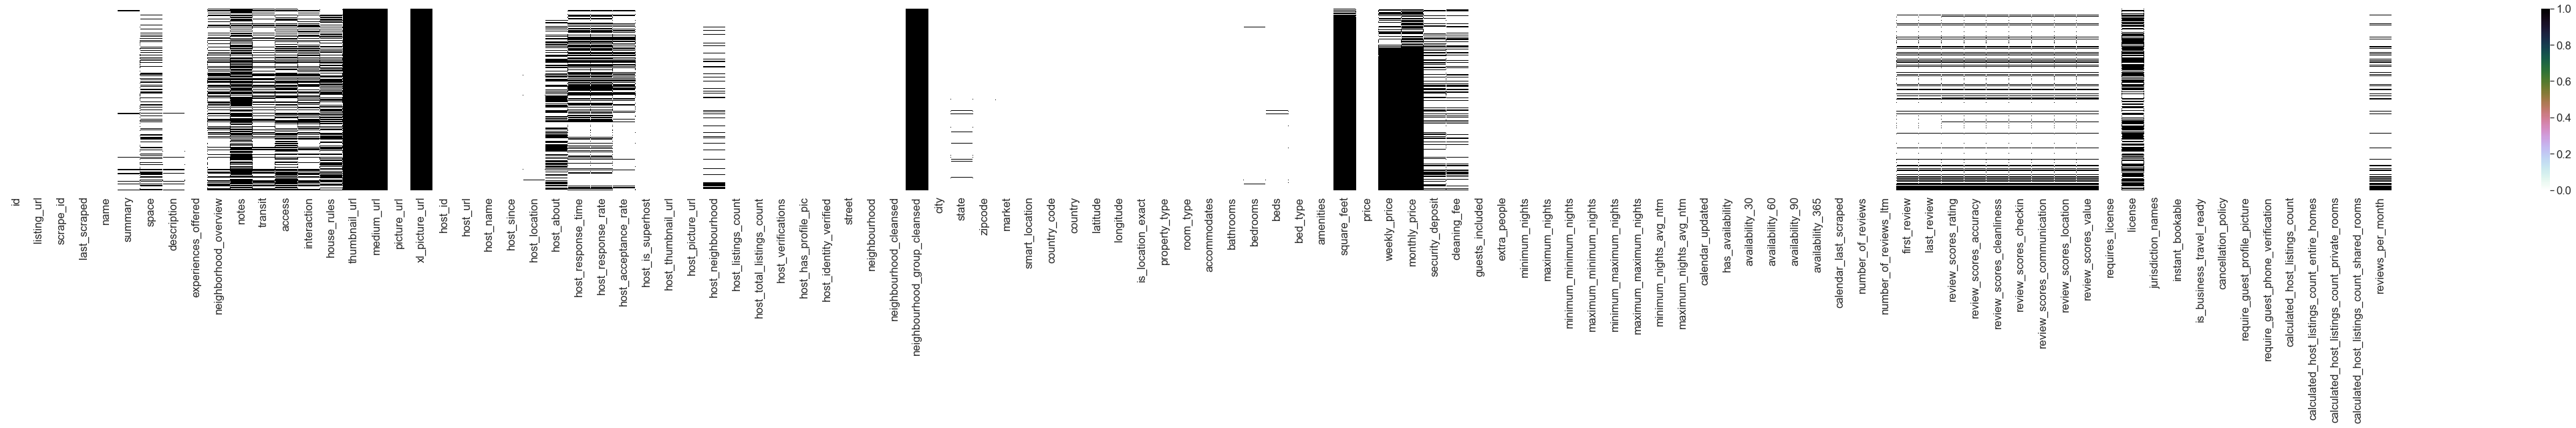

In [6]:
# There are quite a bit of missing values in the data
fig, ax = plt.subplots(figsize = (80, 5))
sns.heatmap(full_data.isna(), cmap = "cubehelix_r", yticklabels='')
plt.show()

## Dropping columns

### Columns with no entries / very few entries / no information:

In [7]:
full_data.isna().sum().sort_values(ascending=False)[0:9]

# These are the columns with almost no entries:
# thumbnail_url
# neighbourhood_group_cleansed 
# medium_url 
# xl_picture_url
# square_feet
# monthly_price
# weekly_price 
# notes
# license 

thumbnail_url                   67323
neighbourhood_group_cleansed    67323
medium_url                      67323
xl_picture_url                  67323
square_feet                     66291
monthly_price                   61479
weekly_price                    58069
notes                           47202
license                         44051
dtype: int64

In [8]:
# jurisdiction_names has no valuable information
full_data.jurisdiction_names[0:3]

0    {"translation missing: en.occupancy.taxes.juri...
1    {"translation missing: en.occupancy.taxes.juri...
2    {"translation missing: en.occupancy.taxes.juri...
Name: jurisdiction_names, dtype: object

In [9]:
full_data[['scrape_id', 'last_scraped', 'experiences_offered','bed_type' ]].head()

# scrape_id - same for all the records
# last_scraped - same for all the records
# experiences_offered - contains only none value
# bed_type - almost all have real beds

,scrape_id,last_scraped,experiences_offered,bed_type
0,20200315231126,2020-03-16,none,Real Bed
1,20200315231126,2020-03-16,none,Pull-out Sofa
2,20200315231126,2020-03-16,none,Real Bed
3,20200315231126,2020-03-16,none,Real Bed
4,20200315231126,2020-03-16,none,Real Bed


In [10]:
full_data.bed_type.value_counts()

Real Bed         64494
Pull-out Sofa     2173
Couch              431
Futon              208
Airbed              17
Name: bed_type, dtype: int64

### Text columns

In [11]:
# I will drop most Text columns, since I will focus on the description column for feature extraction. 

full_data[['name','summary','space',
           'neighborhood_overview',
           'transit','access','interaction', 
           'house_rules']].head(2)
# name 
# summary
# space
# neighborhood_overview
# notes
# transit
# access
# interaction 
# house_rules

,name,summary,space,neighborhood_overview,transit,access,interaction,house_rules
0,zen and calm,Appartement très calme de 50M2 Utilisation de ...,I bedroom appartment in Paris 14,Good restaurants very close the Montparnasse S...,RER B Metro Ligne 13 Pernety Metro Ligne 13 Pl...,"A la demande, vous pouvez avoir accès à la cha...",yes I can help you out,NaN
1,Explore the heart of old Paris,"Cozy, well-appointed and graciously designed s...","Small, well appointed studio apartment at the ...","You are within walking distance to the Louvre,...",The flat is close to two or three major metro ...,"The flat includes its own modern bathroom, a w...",We expect guests to operate rather independent...,This is a small flat in a very old building th...


### Geographical Data

In [12]:
# Since we focus on Paris in this entire analysis, there are several
# columns that can be discarded. When it comes to the column 'is_location_exact',
# since it just differs 150 meters, there is no valuable information in it,
# and can also be removed. 

full_data[['country','country_code','state',
           'city','street','neighbourhood','zipcode',
           'market', 'smart_location', 'is_location_exact'
           ]].head(2)

,country,country_code,state,city,street,neighbourhood,zipcode,market,smart_location,is_location_exact
0,France,FR,Île-de-France,Paris,"Paris, Île-de-France, France",XIV Arrondissement,75014,Paris,"Paris, France",f
1,France,FR,Ile-de-France,Paris,"Paris, Ile-de-France, France",IV Arrondissement,75004,Paris,"Paris, France",t


In [13]:
# In the city column we expect just Paris, but people find quite a few ways to spell it. 
full_data.city.unique()

array(['Paris', 'Paris 11e Arrondissement', 'Paris, 4th arrondissement',
       'Paris-13E-Arrondissement', 'Levallois-Perret',
       'Paris-2E-Arrondissement', 'Paris ', 'Vincennes',
       'Boulogne-Billancourt', '10th arrondissement, Paris',
       'Paris 13e Arrondissement', nan, 'Saint-Mandé',
       'Paris-4E-Arrondissement', 'Paris 4e arrondissement',
       'Joinville-le-Pont', 'PARIS', 'Paris-19E-Arrondissement',
       'Paris 11e arrondissement', 'Le Kremlin-Bicêtre',
       'Paris 9e arrondissement', 'Paris 8è', 'NEUILLY SUR SEINE',
       'PARIS 3eme', 'Issy-les-Moulineaux', 'Paris 1er Arrondissement',
       'paris', ' Deuil-la-Barre ', 'vanves', 'Le Pré-Saint-Gervais',
       'Issy les moulineaux', 'París', 'PARIS 02', 'Parigi',
       'Paris-10E-Arrondissement', 'Paris 9e Arrondissement',
       'Paris 10e Arrondissement', 'Paris 16', 'Paris 6e arrondissement',
       'Paris 10', 'Neuilly Sur Seine ', 'Bagnolet', 'Montrouge',
       'PARIS 05', 'Paris 17', 'Neuilly-sur-

In [14]:
# There has been some cleaning already for the neighbourhoods done, which we will use. There are some differences, since certain neighbourhood have been put together.
#sum((full_data.neighbourhood == full_data.neighbourhood_cleansed) == False)
#full_data.neighbourhood.unique()

full_data.neighbourhood_cleansed.unique()

array(['Observatoire', 'Hôtel-de-Ville', 'Opéra', 'Louvre', 'Popincourt',
       'Buttes-Montmartre', 'Élysée', 'Panthéon', 'Entrepôt', 'Gobelins',
       'Luxembourg', 'Buttes-Chaumont', 'Palais-Bourbon', 'Reuilly',
       'Bourse', 'Ménilmontant', 'Vaugirard', 'Batignolles-Monceau',
       'Temple', 'Passy'], dtype=object)

In [15]:
# There does not seem to be any valuable information in the Street column.

full_data.street.unique()

array(['Paris, Île-de-France, France', 'Paris, Ile-de-France, France',
       'Paris 11e Arrondissement, Île-de-France, France',
       'Paris, IDF, France', 'Paris, Paris, France', 'Paris, France',
       'Paris, Idf, France', 'Paris, IdF, France',
       'Paris, 4th arrondissement, Île-de-France, France',
       'Paris-13E-Arrondissement, Île-de-France, France',
       'Paris, FRANCE, France', 'Levallois-Perret, Île-de-France, France',
       'Paris, Ile de France, France', 'Paris, Île de France, France',
       'Paris-2E-Arrondissement, Île-de-France, France',
       'Paris, France, France', 'Paris , Ile-de-France, France',
       'Vincennes, Île-de-France, France', 'Paris, Ile de france, France',
       'Boulogne-Billancourt, Île-de-France, France',
       'Paris, france, France',
       '10th arrondissement, Paris, Île-de-France, France',
       'Paris 13e Arrondissement, Île-de-France, France', 'FR, France',
       'Saint-Mandé, Île-de-France, France',
       'Paris-4E-Arrondisse

### Picture /  Host / Calendar

In [16]:
# I will keep listing_url, so that we can look it up during the exploration,
# the other information will be dropped. 
# picture_url - interesting if we want to analyse the pictures as well but out of scope otherwise
# host_id - id that is not used anywhere else
# host_url - interesting but we can get to the host page with the listing_url
# host_name
# host_location
# host_about
# host_thumbnail_url
# host_picture_url
# host_neighbourhood
# host_verifications
# calendar_last_scraped
# calendar_updated

full_data[['picture_url','host_id','host_url','host_name',
           'host_location','host_about','host_thumbnail_url','host_picture_url',
           'host_neighbourhood', 'host_verifications', 'calendar_last_scraped', 'calendar_updated'
           ]].head(2)

,picture_url,host_id,host_url,host_name,host_location,host_about,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,calendar_last_scraped,calendar_updated
0,https://a0.muscache.com/im/pictures/baeae9e2-c...,3631,https://www.airbnb.com/users/show/3631,Anne,"Paris, Île-de-France, France",NaN,https://a0.muscache.com/im/users/3631/profile_...,https://a0.muscache.com/im/users/3631/profile_...,Alésia,"['email', 'phone', 'facebook', 'reviews']",2020-03-16,3 weeks ago
1,https://a0.muscache.com/im/pictures/52413/f9bf...,7903,https://www.airbnb.com/users/show/7903,Borzou,"Istanbul, İstanbul, Turkey",We are both journalists based in the Middle Ea...,https://a0.muscache.com/im/users/7903/profile_...,https://a0.muscache.com/im/users/7903/profile_...,Saint-Paul - Ile Saint-Louis,"['email', 'phone', 'facebook', 'google', 'revi...",2020-03-16,1 week ago


In [17]:
# The host seem to come from all over the world
full_data.host_location.nunique()

2193

### Listings count 

In [18]:
#Columns that include highly correlated data or even the same information concerning the listings_count.
#host_listings_count and host_total_listings_count do not seem to display the right amount of listings,
#so they will be droped, together with the correlated calculated counts. On further investigation calculated_host_listings_count gave more accurate information. 

# host_total_listings_count
# host_listings_count
# calculated_host_listings_count_entire_homes
# calculated_host_listings_count_private_rooms 
# calculated_host_listings_count_shared_rooms

full_data[['host_total_listings_count','host_listings_count','calculated_host_listings_count_entire_homes',
           'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms'
           ]].head(2)

,host_total_listings_count,host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,1.0,1.0,1,0,0
1,1.0,1.0,1,0,0


In [109]:
#full_data.loc[((full_data.host_listings_count == full_data.calculated_host_listings_count) == False)]

### Stay Time

In [20]:
#Columns are highly correlated:
# minimum_minimum_nights
# maximum_minimum_nights
# minimum_maximum_nights
# maximum_maximum_nights
# minimum_nights_avg_ntm
# maximum_nights_avg_ntm
# availability_30
# availability_90
# availability_60

In [21]:
full_data[['minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
           'maximum_maximum_nights','minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
           'availability_30','availability_90','availability_60'
           ]].head(1)

,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_90,availability_60
0,2,2,30,30,2.0,30.0,16,76,46


### Reviews

In [22]:
#I will keep the column number of reviews. The following columns will be dropped:
# number_of_reviews_ltm
# reviews_per_month

full_data[['number_of_reviews_ltm','reviews_per_month'
           ]].head(1)

,number_of_reviews_ltm,reviews_per_month
0,1,0.23


### Columns with just one or very few categories - boolean features

In [23]:
# These columns have just one category or very few instances of another.
# has_availability (all)
# host_has_profile_pic 
# is_business_travel_ready (all)
# require_guest_phone_verification 
# require_guest_profile_picture 
# requires_license (all)

features = ['has_availability','host_has_profile_pic',
           'is_business_travel_ready', 'require_guest_phone_verification',
           'require_guest_profile_picture','requires_license'
           ]

full_data[features
           ].head(1)

,has_availability,host_has_profile_pic,is_business_travel_ready,require_guest_phone_verification,require_guest_profile_picture,requires_license
0,t,t,f,f,f,t


In [24]:
def lessthan1percent(list_of_features):
    for i in list_of_features:
        if full_data[i].value_counts(normalize=True)[0] > 0.99 or full_data[i].value_counts(normalize=True)[0] < 0.01:
            print('feature: ' +  i)
            print('one category below 1 percent!')
            print(full_data[i].value_counts(normalize=True)[0])
        else:
            print(i)
            print('both categories above 1 percent!!!')
            print(full_data[i].value_counts(normalize=True)[0])
        print(10 * '___')

In [25]:
lessthan1percent(features)

feature: has_availability
one category below 1 percent!
1.0
______________________________
feature: host_has_profile_pic
one category below 1 percent!
0.9969694718859096
______________________________
feature: is_business_travel_ready
one category below 1 percent!
1.0
______________________________
require_guest_phone_verification
both categories above 1 percent!!!
0.9812099876713753
______________________________
feature: require_guest_profile_picture
one category below 1 percent!
0.9927662165975967
______________________________
feature: requires_license
one category below 1 percent!
0.9999702924706266
______________________________


There is just one feature where one category is slightly above 1 percent. 

In [26]:
full_data.has_availability.value_counts()

t    67323
Name: has_availability, dtype: int64

In [27]:
full_data.host_has_profile_pic.value_counts(normalize=True)[0]

0.9969694718859096

In [28]:
full_data.is_business_travel_ready.value_counts()

f    67323
Name: is_business_travel_ready, dtype: int64

In [29]:
full_data.requires_license.value_counts()

t    67321
f        2
Name: requires_license, dtype: int64

In [30]:
full_data.require_guest_profile_picture.value_counts()

f    66836
t      487
Name: require_guest_profile_picture, dtype: int64

### How to deal with boolean features

In [31]:
full_data.replace({'f': False, 't': True}, inplace=True)

### Summary

Columns with no entries / very few entries / no information:
At a first glance you see that certain columns (thumbnail_url, etc.) dont have any information in them, I can therefore not use them for my EDA and model.

* weekly_price 
* monthly_price 
* square_feet 
* license 
* jurisdiction_names 
* medium_url 
* thumbnail_url 
* notes
* neighbourhood_group_cleansed 
* xl_picture_url 
* scrape_id - same for all the records
* last_scraped - same for all the records
* experiences_offered - contains only none value
* bed_type - almost all have real beds

Text columns (The description column will be used to extract information):
* name 
* summary
* space
* neighborhood_overview
* transit
* access
* interaction 
* house_rules

Geographical data:

Since we just want to predict prices for Paris and thats what our data consists of, we will drop the city column. The 'market' column as well as the 'smart location' column also do not include valuable information with only Paris in it. Also the country column is not usefull for our model, as well as the country code and the state. 
Moreover the street column does not seem to have good information.
There is also the column neighbourhood and neighbourhood_cleansed, we will keep neighbourhood cleansed, so it will match the also provided Geojson file. Since we include the neighbourhood column I will also drop the zipcodes.The column 'is_location_exact' will also not be integrated.

* country
* country_code
* state
* city
* street
* neighbourhood
* zipcode
* market
* smart_location
* is_location_exact - unimportant as it could be inacurate up to 150 meters http://insideairbnb.com/about.html#disclaimers

Further data for picture/host/calendar will be dropped, listing_url will be kept for data exploration:

* picture_url - interesting if we want to analyse the pictures as well but out of scope otherwise
* host_id - id that is not used anywhere else
* host_url - interesting but we can get to the host page with the listing_url
* host_name
* host_location
* host_about
* host_thumbnail_url
* host_picture_url
* host_neighbourhood
* host_verifications
* calendar_last_scraped
* calendar_updated

Columns that include highly correlated data or even the same information concerning the listings_count:

host_listings_count and host_total_listings_count do not seem to display the right amount of listings so they will be droped. Together with the correlated calculated counts. 

* host_total_listings_count
* host_listings_count
* calculated_host_listings_count_entire_homes
* calculated_host_listings_count_private_rooms 
* calculated_host_listings_count_shared_rooms

Columns that include highly correlated data or even the same information concering the required stay time:

Since the count of minimum and maximum stays can vary over the year, 
there are not only the minimum nights in the dataset, but also the minimum_minimum_nights, etc.
For our exploration we will only work with the minimum_nights, etc. default value
I will keep availability_365 since it is highly correlated with the others.

* minimum_minimum_nights
* maximum_minimum_nights
* minimum_maximum_nights
* maximum_maximum_nights
* minimum_nights_avg_ntm
* maximum_nights_avg_ntm
* availability_30
* availability_90
* availability_60

Columns that include highly correlated data or even the same information concering the reviews:

* number_of_reviews_ltm
* reviews_per_month


Several columns only contain one category / or very few from the other category:

* has_availability (all)
* host_has_profile_pic 
* is_business_travel_ready (all)
* require_guest_phone_verification 
* require_guest_profile_picture 
* requires_license (all)

In [32]:
raw_data = full_data.drop(['xl_picture_url','neighbourhood_group_cleansed','thumbnail_url',
                           'medium_url','jurisdiction_names','license','square_feet',
                           'monthly_price','weekly_price','country','country_code',
                           'state','city','street','neighbourhood','zipcode','market', 'availability_60',
                           'smart_location','is_location_exact','host_id','scrape_id', 'availability_90',
                           'last_scraped','name','summary','space', 'availability_30',
                           'neighborhood_overview','notes','transit','access','interaction',
                           'house_rules','experiences_offered','picture_url','host_id','bed_type',
                           'host_url','host_name','host_location','host_about','host_thumbnail_url',
                           'host_picture_url','host_neighbourhood','host_verifications','calendar_last_scraped',
                           'host_total_listings_count', 'host_listings_count','calendar_updated',
                           'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 
                           'calculated_host_listings_count_shared_rooms','minimum_minimum_nights', 'maximum_minimum_nights',
                           'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
                           'has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 
                           'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license',
                           'number_of_reviews_ltm', 'reviews_per_month'], axis=1)

raw_data.set_index('id', inplace = True)

In [33]:
raw_data.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)

In [34]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67323 entries, 3109 to 42913034
Data columns (total 39 columns):
listing_url                       67323 non-null object
description                       66206 non-null object
host_since                        67315 non-null object
host_response_time                37207 non-null object
host_response_rate                37207 non-null object
host_acceptance_rate              47482 non-null object
host_is_superhost                 67315 non-null object
host_identity_verified            67315 non-null object
neighbourhood                     67323 non-null object
latitude                          67323 non-null float64
longitude                         67323 non-null float64
property_type                     67323 non-null object
room_type                         67323 non-null object
accommodates                      67323 non-null int64
bathrooms                         67272 non-null float64
bedrooms                          67179 non

# Feature Engineering

## A closer look at the price columns

In [35]:
# All prices are euro prices and should be transformed to floats for the regression
raw_data[['price','cleaning_fee', 'extra_people', 'security_deposit']].head()

,price,cleaning_fee,extra_people,security_deposit
id,,,,
3109,$60.00,$60.00,$0.00,$150.00
5396,$115.00,$36.00,$0.00,$0.00
7397,$119.00,$50.00,$10.00,$200.00
7964,$130.00,$60.00,$20.00,$500.00
9359,$75.00,$200.00,$30.00,"$1,500.00"


In [36]:
raw_data[['price','cleaning_fee', 'extra_people', 'security_deposit']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67323 entries, 3109 to 42913034
Data columns (total 4 columns):
price               67323 non-null object
cleaning_fee        50501 non-null object
extra_people        67323 non-null object
security_deposit    47641 non-null object
dtypes: object(4)
memory usage: 2.6+ MB


In [37]:
raw_data.cleaning_fee.fillna('0', inplace=True)
raw_data.security_deposit.fillna('0', inplace=True)

In [38]:
price_list = ['price','cleaning_fee', 'extra_people', 'security_deposit']
for i in price_list:
    raw_data[i] = [float(re.sub(r'[^\d.]', '', a)) for a in raw_data[i]]

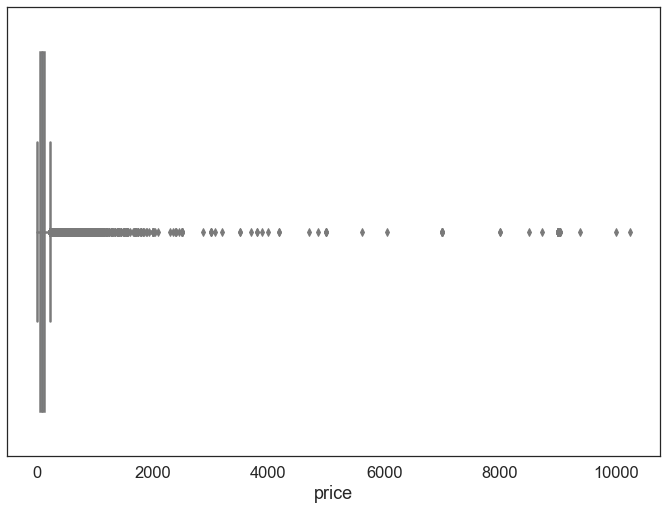

In [39]:
sns.boxplot(x=raw_data["price"]);

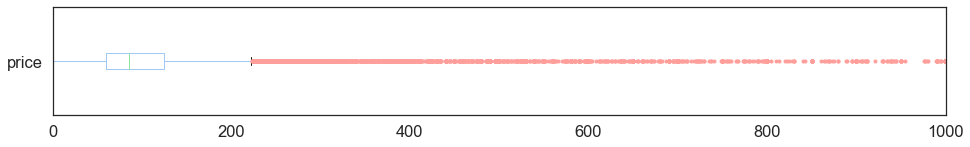

In [40]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
raw_data['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

In [41]:
# Prices above 600 and equal to zero are dropped to make the dataset more realistic and stable. 
raw_data.drop(raw_data[ (raw_data.price > 600) | (raw_data.price == 0) ].index, axis=0, inplace=True)

## Bedrooms / Bathrooms / Beds 

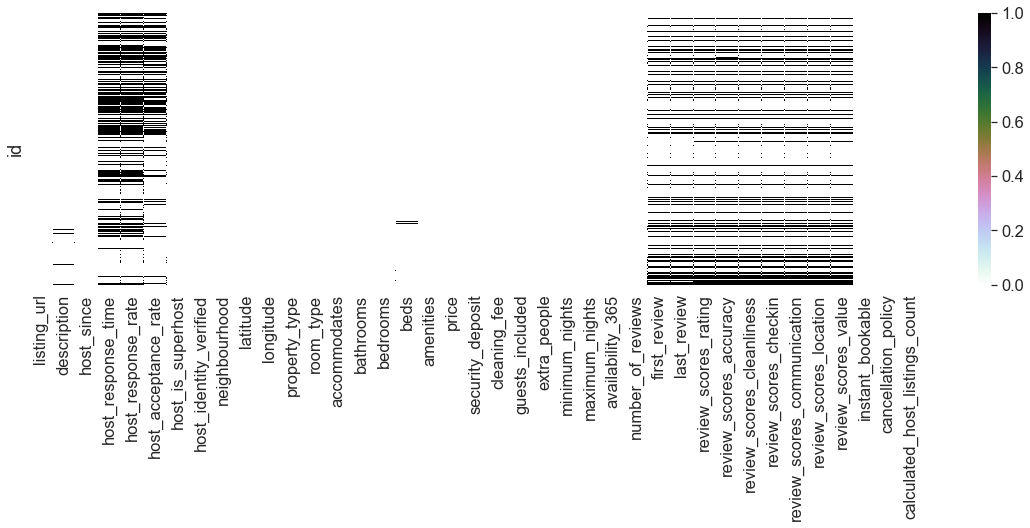

In [42]:
fig, ax = plt.subplots(figsize = (20, 5))
sns.heatmap(raw_data.isna(), cmap = "cubehelix_r", yticklabels='')
plt.show()

In [43]:
# just a few missing columns
raw_data.dropna(subset=['bathrooms', 'bedrooms', 'beds', ], inplace=True)

## host 

### host_identity_verified 

In [44]:
raw_data.host_identity_verified.unique()

array([False, True, nan], dtype=object)

In [45]:
raw_data[['host_identity_verified']] = raw_data[['host_identity_verified']].applymap(bool)

In [46]:
raw_data.host_identity_verified.unique()

array([False,  True])

### host_is_superhost 

In [47]:
# just a few missing columns, that can be dropped
raw_data.dropna(subset=['host_is_superhost'], inplace=True)
raw_data[['host_is_superhost']] = raw_data[['host_is_superhost']].applymap(bool)

In [48]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65575 entries, 3109 to 42913034
Data columns (total 39 columns):
listing_url                       65575 non-null object
description                       64559 non-null object
host_since                        65575 non-null object
host_response_time                35811 non-null object
host_response_rate                35811 non-null object
host_acceptance_rate              46031 non-null object
host_is_superhost                 65575 non-null bool
host_identity_verified            65575 non-null bool
neighbourhood                     65575 non-null object
latitude                          65575 non-null float64
longitude                         65575 non-null float64
property_type                     65575 non-null object
room_type                         65575 non-null object
accommodates                      65575 non-null int64
bathrooms                         65575 non-null float64
bedrooms                          65575 non-nul

### host_since 

In [49]:
# Converting to datetime
raw_data.host_since = pd.to_datetime(raw_data.host_since) 
# Calculating the number of days
raw_data['host_days_active'] = (datetime(2020, 3, 20) - raw_data.host_since).astype('timedelta64[D]')
# Printing mean and median
print("Mean days as host:", round(raw_data['host_days_active'].mean(),0))
print("Median days as host:", raw_data['host_days_active'].median())
# Replacing null values with the median
raw_data.host_days_active.fillna(raw_data.host_days_active.median(), inplace=True)

Mean days as host: 1642.0
Median days as host: 1728.0


### host_acceptance_rate 

In [50]:
# Removing the % sign from the host_response_rate string and converting to an integer
raw_data['host_acceptance_rate'] = [float(re.sub(r'[^\d.]', '', a)) if type(a)!=float else float(a) for a in raw_data['host_acceptance_rate']]
# Bin into four categories
raw_data.host_acceptance_rate = pd.cut(raw_data.host_acceptance_rate, bins=[0, 60, 99, 100], labels=['0-59%', '60-99%', '100%'], include_lowest=True)
# Converting to string
raw_data.host_acceptance_rate = raw_data.host_acceptance_rate.astype('str')
# Replace nulls with 'unknown'
raw_data.host_acceptance_rate.replace('nan', 'unknown', inplace=True)
# Category counts
raw_data.host_acceptance_rate.value_counts()

60-99%     21210
unknown    19544
100%       16019
0-59%       8802
Name: host_acceptance_rate, dtype: int64

### host_response_rate 

In [51]:
# Removing the % sign from the host_response_rate string and converting to an integer
raw_data['host_response_rate'] = [float(re.sub(r'[^\d.]', '', a)) if type(a)!=float else float(a) for a in raw_data['host_response_rate']]
# Bin into four categories
raw_data.host_response_rate = pd.cut(raw_data.host_response_rate, bins=[0, 60, 99, 100], labels=['0-59%', '60-99%', '100%'], include_lowest=True)
# Converting to string
raw_data.host_response_rate = raw_data.host_response_rate.astype('str')
# Replace nulls with 'unknown'
raw_data.host_response_rate.replace('nan', 'unknown', inplace=True)
# Category counts
raw_data.host_response_rate.value_counts()

unknown    29764
100%       25675
60-99%      7791
0-59%       2345
Name: host_response_rate, dtype: int64

### host_response_time 

In [52]:
# Replace nulls with 'unknown'
raw_data.host_response_time.fillna("unknown", inplace=True)
# Category counts
raw_data.host_response_time.value_counts()

unknown               29764
within an hour        21232
within a few hours     7410
within a day           5850
a few days or more     1319
Name: host_response_time, dtype: int64

## amenities 

### How many amenities per listing are there?

In [53]:
# Count the amenities and create a new feature with it
def amenities_counter(x):
    return len(x.split(","))

raw_data['amenities_count'] = raw_data.amenities.map(amenities_counter)
raw_data.head(3)

,listing_url,description,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,host_days_active,amenities_count
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3109,https://www.airbnb.com/rooms/3109,I bedroom appartment in Paris 14 Good restaura...,2008-10-14,within a few hours,100%,0-59%,False,False,Observatoire,48.83349,2.31852,Apartment,Entire home/apt,2,1.0,0.0,1.0,"{Internet,Wifi,Kitchen,""Paid parking off premi...",60.0,150.0,60.0,1,0.0,2,30,351,9,2016-12-27,2019-10-24,100.0,10.0,10.0,10.0,10.0,10.0,10.0,False,flexible,1,4175.0,16
5396,https://www.airbnb.com/rooms/5396,"Cozy, well-appointed and graciously designed s...",2009-02-14,within an hour,100%,100%,False,True,Hôtel-de-Ville,48.85100,2.35869,Apartment,Entire home/apt,2,1.0,0.0,1.0,"{Internet,Wifi,Kitchen,Heating,Washer,""Smoke d...",115.0,0.0,36.0,1,0.0,1,2,32,215,2009-06-30,2020-03-01,90.0,8.0,8.0,9.0,9.0,10.0,8.0,True,strict_14_with_grace_period,1,4052.0,17
7397,https://www.airbnb.com/rooms/7397,"VERY CONVENIENT, WITH THE BEST LOCATION ! PLEA...",2008-08-30,within an hour,100%,60-99%,True,True,Hôtel-de-Ville,48.85758,2.35275,Apartment,Entire home/apt,4,1.0,2.0,2.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",119.0,200.0,50.0,2,10.0,4,23,238,268,2011-04-08,2020-02-26,94.0,10.0,9.0,10.0,10.0,10.0,10.0,False,moderate,1,4220.0,30


### What amenities are in the dataset?

In [54]:
results = Counter()
raw_data['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(100)

[('Heating', 62192),
 ('Kitchen', 61811),
 ('Wifi', 61535),
 ('Essentials', 61430),
 ('Washer', 50578),
 ('Hangers', 46886),
 ('Smoke detector', 46862),
 ('Hair dryer', 45258),
 ('Iron', 44446),
 ('TV', 42931),
 ('Shampoo', 41437),
 ('Laptop friendly workspace', 40100),
 ('Hot water', 35576),
 ('Refrigerator', 29625),
 ('Dishes and silverware', 29413),
 ('Elevator', 26231),
 ('Coffee maker', 24918),
 ('Bed linens', 24141),
 ('Cooking basics', 23839),
 ('Microwave', 22427),
 ('Oven', 20922),
 ('Internet', 19461),
 ('Stove', 19406),
 ('Family/kid friendly', 19313),
 ('Dryer', 18964),
 ('Cable TV', 15502),
 ('Carbon monoxide detector', 15142),
 ('Dishwasher', 13529),
 ('Host greets you', 12781),
 ('Paid parking off premises', 12732),
 ('Extra pillows and blankets', 10780),
 ('Buzzer/wireless intercom', 10566),
 ('Private entrance', 9496),
 ('Smoking allowed', 9150),
 ('Long term stays allowed', 8984),
 ('First aid kit', 8910),
 ('Luggage dropoff allowed', 8603),
 ('Breakfast', 8424),
 ('F

In [55]:
sub_df = pd.DataFrame(results.most_common(20), columns=['amenity', 'count'])

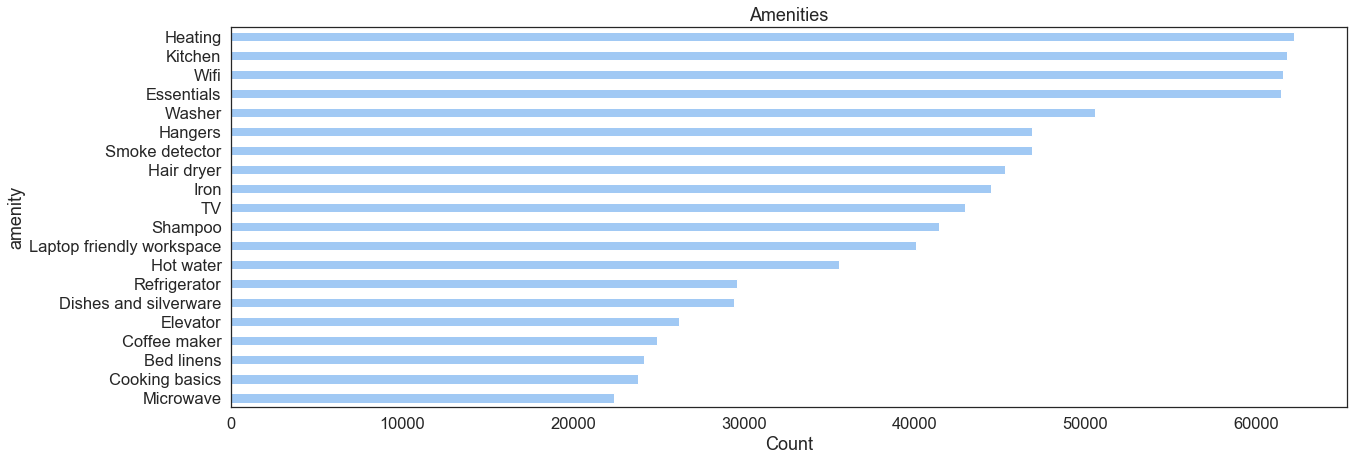

In [56]:
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(20,7), legend=False,
                                                      title='Amenities')
plt.xlabel('Count');

In [58]:
list_new_features = [['check_in_24h','check_in_24h'],
                     ['Air conditioning|Central air conditioning','air_conditioning'],
                     ['Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV','high_end_electronics'],
                     ['BBQ grill|Fire pit|Propane barbeque','bbq'], 
                     ['Balcony|Patio','balcony'],
                     ['Bed linens','bed_linen'],
                     ['Breakfast','breakfast'],
                     ['TV','tv'],
                     ['Coffee maker','coffee_machine'],
                     ['Cooking basics','cooking_basics'],
                     ['Dishwasher|Dryer|Washer','household appliance'],
                     ['Elevator','elevator'],
                     ['Exercise equipment|Gym|gym','gym'],
                     ['Family/kid friendly|Children|children','child_friendly'],
                     ['parking','parking'],
                     ['Garden|Outdoor|Sun loungers|Terrace', 'outdoor_space'],
                     ['Host greets you', 'host_greeting'],
                     ['Hot tub|Jetted tub|hot tub|Sauna|Pool|pool', 'hot_tub_sauna_or_pool'],
                     ['Internet|Pocket wifi|Wifi', 'internet'],
                     ['Long term stays allowed', 'long_term_stays'],
                     ['Pets|pet|Cat(s)|Dog(s)', 'pets_allowed'],
                     ['Private entrance', 'private_entrance'],
                     ['Safe|Security system', 'secure'],
                     ['Self check-in', 'self_check_in'],
                     ['Smoking allowed', 'smoking_allowed'],
                     ['Step-free access|Wheelchair|Accessible','accessible'],
                     ['Suitable for events','event_suitable']]

for a,n in list_new_features:
    raw_data.loc[raw_data['amenities'].str.contains(a), n] = 1

In [59]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = raw_data.iloc[:,40:].columns
raw_data[cols_to_replace_nulls] = raw_data[cols_to_replace_nulls].fillna(0)
# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in raw_data.iloc[:,40:].columns:
    if raw_data[col].sum() < len(raw_data)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)
# Dropping infrequent amenity features
raw_data.drop(infrequent_amenities, axis=1, inplace=True)
# Dropping the original amenity feature
raw_data.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'air_conditioning', 'high_end_electronics', 'bbq', 'balcony', 'gym', 'outdoor_space', 'hot_tub_sauna_or_pool', 'pets_allowed', 'secure', 'self_check_in', 'accessible', 'event_suitable']


In [60]:
raw_data.iloc[:,40:] = raw_data.iloc[:,40:].applymap(bool)

## review

### first_review and last_review

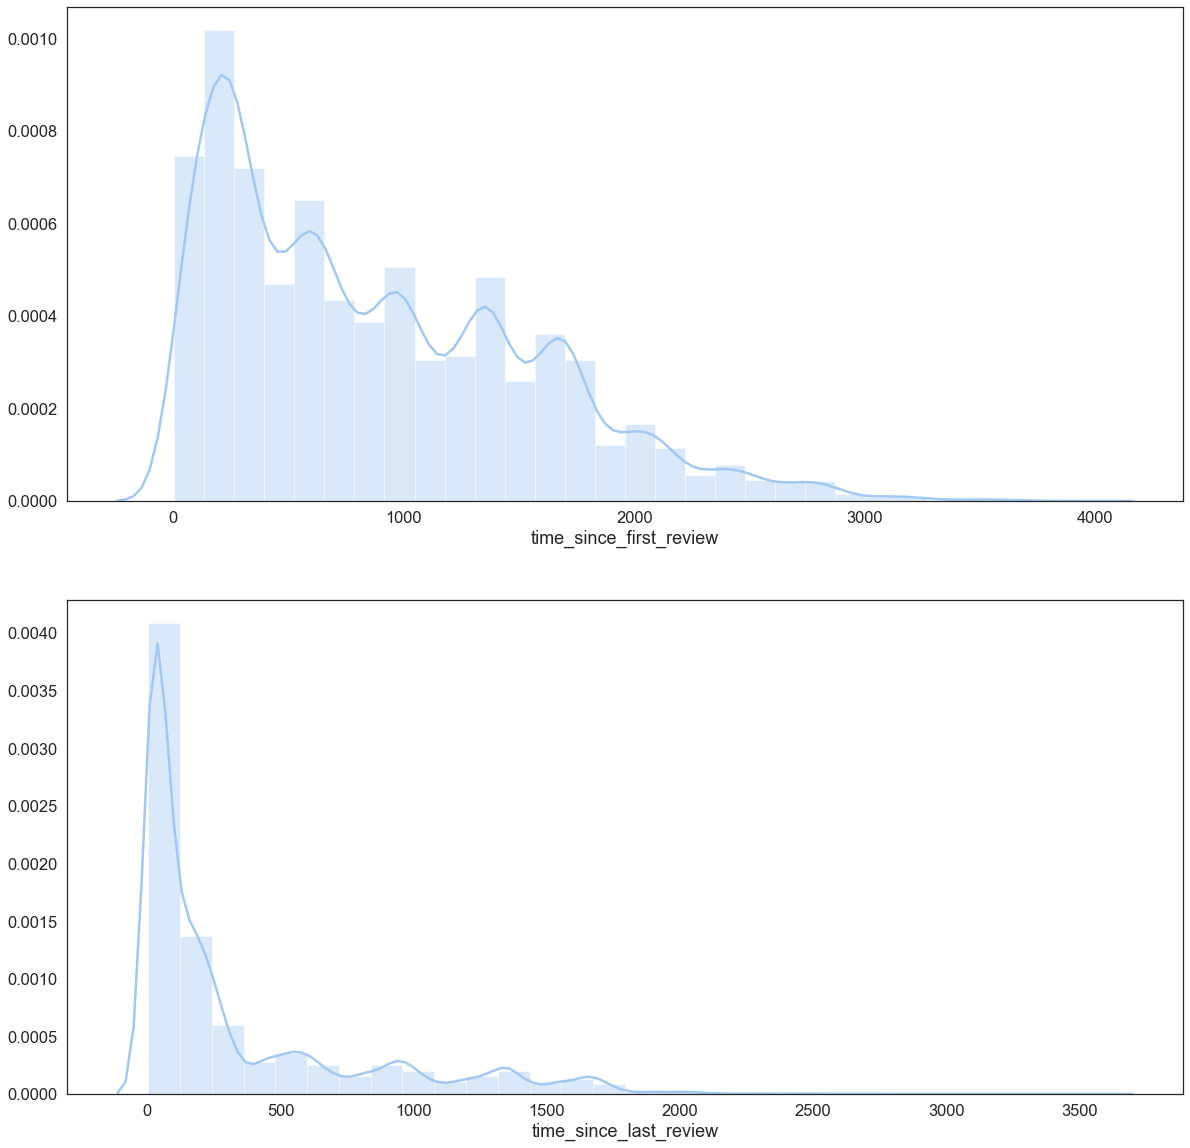

In [61]:
#most listings have have their first and last review quite recently, since they are not on the market for too long
fig, ax = plt.subplots(nrows=2,figsize=(20,20))
review_list = ['first_review', 'last_review']
for idx, i in enumerate(review_list):
    raw_data[i] = pd.to_datetime(raw_data[i])
    raw_data['time_since_' + str(i)] = (datetime(2020, 3, 19) - raw_data[i]).astype('timedelta64[D]')
    sns.distplot(raw_data['time_since_' + str(i)],ax=ax[idx], bins=30)

In [62]:
review_list_time = ['time_since_first_review', 'time_since_last_review']
bins = [[0, 182, 365, 730, 1460, max(raw_data.time_since_first_review)],
        [0, 14, 60, 182, 365, max(raw_data.time_since_last_review)]]
labels = [['0-6 months','6-12 months', '1-2 years','2-3 years','4+ years'],
          ['0-2 weeks', '2-8 weeks', '2-6 months','6-12 months', '1+ year']]
                   
for idx, i in enumerate(review_list_time):
    raw_data[i] = pd.cut(raw_data[i], bins=bins[idx], labels=labels[idx], include_lowest=True)
    raw_data[i] = raw_data[i].astype('str')
    raw_data[i].fillna('no reviews', inplace=True)

### review_scores

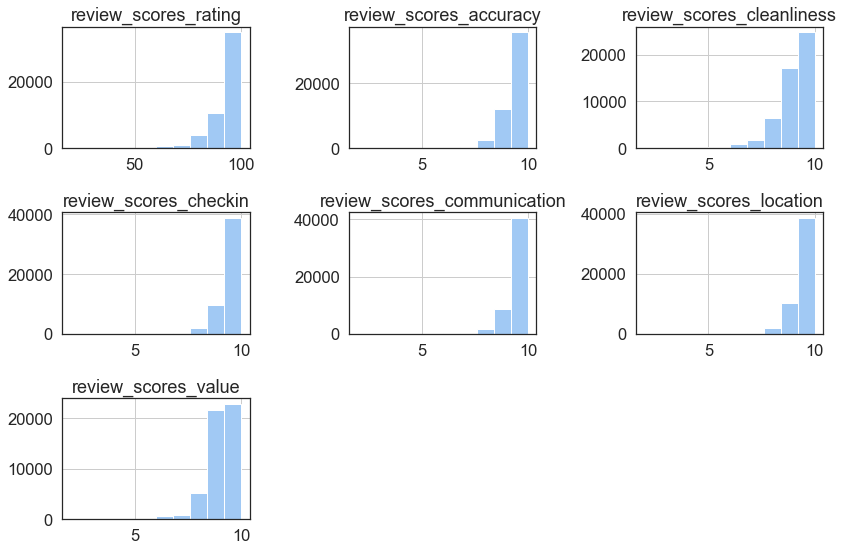

In [63]:
#most listings have a high review score, it is skewed to the right. But it also means that being close to 50 or 5 is really bad. 
review_list = list(raw_data.columns[raw_data.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for idx, i in enumerate(review_list):
    ax = fig.add_subplot(3,3,idx+1)
    raw_data[i].hist(bins=10)
    ax.set_title(i)
fig.tight_layout()
plt.show()

In [64]:
# I will make bins for the review scores
review_scores_list = list(raw_data.columns[raw_data.columns.str.startswith("review_scores") == True])
bins = [0, 8, 9, 10]
labels = ['0-8/10', '9/10', '10/10']
                   
for i in review_scores_list[1:]:
    raw_data[i] = pd.cut(raw_data[i], bins=bins, labels=labels, include_lowest=True)
    raw_data[i] = raw_data[i].astype('str')
    raw_data[i].fillna('no reviews', inplace=True)

In [65]:
bins = [0, 80, 95, 100]
labels = ['0-79/100', '80-94/100', '95-100/100']
raw_data[review_scores_list[0]] = pd.cut(raw_data[review_scores_list[0]], bins=bins, labels=labels, include_lowest=True)
raw_data[review_scores_list[0]] = raw_data[review_scores_list[0]].astype('str')
raw_data[review_scores_list[0]].fillna('no reviews', inplace=True)

## Distance to Centroid of Paris

In [67]:
# With this function and the geo data of the listing I will create a feature for distance to center
def distance_to_mid(lat, lon):
    paris_centre = (48.864716, 2.349014)
    accommodation = (lat, lon)
    return great_circle(paris_centre, accommodation).km

In [68]:
raw_data['distance'] = raw_data.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

## Size

In [69]:
# Test for possible ways to extract size
s = full_data.description[1]

re_list = [r'\b([0-9]+) ?m2 ?', r'\b([0-9]+) ?qm ?',
           r'\b([0-9]+) ?sqm ?', r'\b([0-9]+) ?m² ?',
           r'\b([0-9]+) ?square ?', r'\b([0-9]+) ?Square ?']
matches = []
for r in re_list:
    result = re.search(r, s)
    if result:
        matches.append(result.group(0)) 
print(matches) 
s

['30 square ']


"Cozy, well-appointed and graciously designed studio apartment that mixes old and new aesthetics at the very heart of Paris, on the famous Isle St Louis that is a stone's throw from Le Marais, Quartier Latin, Notre Dame and Le Louvre. Small, well appointed studio apartment at the very heart of Paris, on the famous Isle St Louis. FOUR-NIGHT MINIMUM.  We are looking for quiet persons or couples to rent our fully equipped and furnished studio (about 30 square meters or 300 square feet) in central Paris on the famous Isle St. Louis. Please contact us for more information. Discounts available for longer stays. The location is superb. Pick up fresh bread at the nearby boulangerie and some exquisite cheese at the local fromagerie for breakfast. Take a late night stroll along the nearby Seine. Bar hop in the adjacent Marais district, the East Village of Paris. The flat includes its own modern bathroom, a washing machine, stove, oven, toaster and coffee press. For sleeping there is only a fold-

In [70]:
# function to extract price
def extract_numbers(list_of_regex):
    for idx, s in enumerate(list_of_regex):
        raw_data['size'+ str(idx)] = raw_data['description'].str.extract(s, expand=True)
    raw_data['size'] = raw_data[raw_data.columns[57:]].apply(lambda x: ','.join(x.dropna().astype(str)), axis=1)
    raw_data['size'] = raw_data['size'].apply(lambda x: min(x.split(',')))
    raw_data['size'] = raw_data['size'].replace(r'^\s*$', np.nan, regex=True)
    for idx, s in enumerate(list_of_regex):
        raw_data.drop('size'+ str(idx), axis=1, inplace=True)
    print('NaNs in size_column absolute:     ', raw_data['size'].isna().sum())
    print('NaNs in size_column in percentage:', round(raw_data['size'].isna().sum()/len(raw_data)*100,3), '%')

In [71]:
re_list = [r'\b([0-9]+) ?m2 ?', 
           r'\b([0-9]+) ?qm ?', 
           r'\b([0-9]+) ?sqm ?', 
           r'\b([0-9]+) ?m² ?',  
           r'\b([0-9]+) ?square ?',
           r'\b([0-9]+) ?Square ?']

extract_numbers(re_list)

NaNs in size_column absolute:      39935
NaNs in size_column in percentage: 60.9 %


In [72]:
sub_df = raw_data[['accommodates', 'bathrooms', 'bedrooms', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'distance', 'size']]

In [73]:
# split datasets
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

# define X
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

# define y
y_train = train_data['size']

In [74]:
print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (25640, 9)
Shape of Test Data:     (39935, 9)

Shape of X_train: (25640, 8)
Shape of X_test: (39935, 8)

Shape of y_train: (25640,)


In [75]:
# import Linear Regression
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit model to training data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [76]:
# making predictions
y_test = linreg.predict(X_test)

In [77]:
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']
print(y_test.shape)
y_test.head()

(39935, 1)


,size
0,35.978620
1,63.643509
2,51.374765
3,21.857724
4,53.049762


In [78]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)
y_test.head()

,size
prelim,
3109,35.978620
9359,63.643509
10710,51.374765
11170,21.857724
11798,53.049762


In [79]:
new_test_data = pd.concat([X_test, y_test], axis=1)

In [80]:
print(new_test_data.shape)
new_test_data.head()

(39935, 9)


,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
3109,2,1.0,0.0,60.0,150.0,0.0,1,4.127306,35.978620
9359,2,1.0,1.0,200.0,1500.0,30.0,1,0.648235,63.643509
10710,4,1.0,1.0,60.0,600.0,10.0,3,2.885256,51.374765
11170,2,1.0,0.0,0.0,0.0,0.0,2,2.008292,21.857724
11798,3,1.0,1.0,40.0,600.0,10.0,2,4.736548,53.049762


In [81]:
new_test_data['size'].isna().sum()

0

In [82]:
sub_df_new = pd.concat([new_test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head()

(65575, 9)


,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
3109,2,1.0,0.0,60.0,150.0,0.0,1,4.127306,35.9786
9359,2,1.0,1.0,200.0,1500.0,30.0,1,0.648235,63.6435
10710,4,1.0,1.0,60.0,600.0,10.0,3,2.885256,51.3748
11170,2,1.0,0.0,0.0,0.0,0.0,2,2.008292,21.8577
11798,3,1.0,1.0,40.0,600.0,10.0,2,4.736548,53.0498


In [83]:
sub_df_new['size'].isna().sum()

0

In [84]:
# prepare the multiple columns before concatening
raw_data.drop(['accommodates', 'bathrooms', 'bedrooms', 'cleaning_fee', 
              'security_deposit', 'extra_people', 'guests_included', 'distance', 'size'], 
               axis=1, inplace=True)

In [85]:
raw_data = pd.concat([sub_df_new, raw_data], axis=1)

In [86]:
raw_data.describe()

,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,latitude,longitude,beds,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,calculated_host_listings_count,host_days_active,amenities_count
count,65575.000000,65575.000000,65575.000000,65575.000000,65575.000000,65575.000000,65575.000000,65575.000000,65575.000000,65575.000000,65575.000000,65575.000000,65575.000000,6.557500e+04,65575.000000,65575.000000,65575.000000,65575.000000,65575.000000
mean,3.042791,1.114868,1.074907,30.938681,285.712482,5.647274,1.488494,2.871435,48.864121,2.345580,1.652810,107.535067,5.279665,8.573175e+02,84.531376,20.712070,7.965124,1641.893923,18.505909
std,1.519517,0.629130,0.971488,34.386889,493.088177,13.721923,1.093747,1.418917,0.018451,0.033434,1.091482,80.789892,43.982086,3.905551e+04,121.877648,42.301794,33.423409,819.676831,8.306706
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.011736,48.813400,2.225070,0.000000,8.000000,1.000000,1.000000e+00,0.000000,0.000000,1.000000,5.000000,1.000000
25%,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.813001,48.850715,2.324430,1.000000,60.000000,1.000000,3.000000e+01,0.000000,1.000000,1.000000,1075.000000,12.000000
50%,2.000000,1.000000,1.000000,25.000000,150.000000,0.000000,1.000000,2.848247,48.865240,2.348530,1.000000,85.000000,2.000000,1.125000e+03,5.000000,6.000000,1.000000,1728.000000,17.000000
75%,4.000000,1.000000,1.000000,50.000000,400.000000,5.000000,2.000000,3.857170,48.879205,2.370860,2.000000,120.000000,4.000000,1.125000e+03,147.000000,21.000000,1.000000,2221.000000,24.000000
max,22.000000,50.000000,50.000000,600.000000,4740.000000,270.000000,100.000000,9.907948,48.906060,2.467050,50.000000,600.000000,9999.000000,1.000000e+07,365.000000,867.000000,301.000000,4220.000000,91.000000


In [87]:
raw_data['size'].isna().sum()

0

In [88]:
raw_data['size'].head()

3109    35.9786
5396         30
7397         40
7964         75
9359    63.6435
Name: size, dtype: object

In [89]:
raw_data['size'] = raw_data['size'].astype(float)

In [90]:
raw_data['size'].describe()

count    65575.000000
mean        52.593818
std        262.219360
min        -58.378364
25%         32.000000
50%         45.539253
75%         57.460527
max      47100.000000
Name: size, dtype: float64

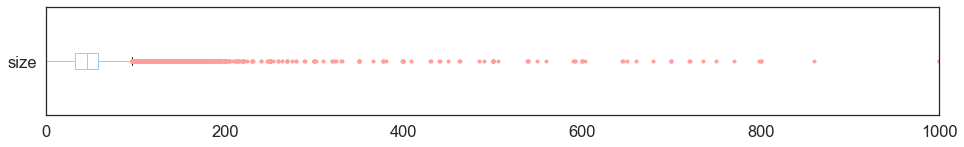

In [91]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
raw_data['size'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

In [92]:
# To be save I will cute all the listings with sizes below 0 and above 300 m2.
raw_data.drop(raw_data[ (raw_data['size'] <= 0.) | (raw_data['size'] > 300.) ].index, axis=0, inplace=True)

In [93]:
print("The dataset has {} rows and {} columns - after being engineered.".format(*raw_data.shape))

The dataset has 65442 rows and 58 columns - after being engineered.


## Subway

In [94]:
# With this feature I want to extract if metro, subway etc. is part of the description, and maybe has some effect on the price.
raw_data.dropna(subset=['description', ], inplace=True)
raw_data.loc[raw_data['description'].str.contains('subway|Metro|metro'), 'subway'] = 1
raw_data['subway'].fillna(0, inplace=True)

In [95]:
raw_data['subway'].value_counts()

0.0    45945
1.0    18481
Name: subway, dtype: int64

In [96]:
raw_data[['subway']] = raw_data[['subway']].applymap(bool)

## property_type / room_type

In [97]:
raw_data.property_type.value_counts()

Apartment             58514
Condominium            1940
Loft                   1182
Boutique hotel          917
Serviced apartment      452
House                   432
Townhouse               242
Hotel                   217
Bed and breakfast       148
Other                    99
Guesthouse               93
Guest suite              46
Aparthotel               33
Hostel                   30
Tiny house               30
Boat                     11
Villa                     8
Houseboat                 7
Earth house               3
Cave                      3
Bungalow                  2
Farm stay                 2
Dome house                2
Nature lodge              2
Cottage                   2
Barn                      2
Igloo                     1
Camper/RV                 1
Campsite                  1
Plane                     1
Island                    1
Cabin                     1
Dorm                      1
Name: property_type, dtype: int64

In [98]:
# Some weird properties can be found in the dataset. 
raw_data[raw_data['property_type'] == 'Igloo']

,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,listing_url,description,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood,latitude,longitude,property_type,room_type,beds,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,host_days_active,amenities_count,bed_linen,breakfast,tv,coffee_machine,cooking_basics,household appliance,elevator,child_friendly,parking,host_greeting,internet,long_term_stays,private_entrance,smoking_allowed,time_since_first_review,time_since_last_review,subway
4311177,4,2.5,1.0,0.0,0.0,0.0,1,1.297616,78.52994,https://www.airbnb.com/rooms/4311177,Vous revez de vivre une soirée comme un vrai ...,2014-07-28,unknown,unknown,unknown,False,True,Hôtel-de-Ville,48.85558,2.36005,Igloo,Shared room,4.0,500.0,1,1125,0,0,NaT,NaT,nan,nan,nan,nan,nan,nan,nan,False,flexible,1,2062.0,26,False,True,True,False,False,True,True,True,True,False,True,False,False,True,nan,nan,False


<img src="data/Igloo.png"> 

In [99]:
# Replacing categories that are types of houses or apartments
raw_data.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',  
    }, inplace=True)

# Replacing other categories with 'other'
raw_data.loc[~raw_data.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [100]:
raw_data.room_type.value_counts()

Entire home/apt    56271
Private room        6831
Hotel room           935
Shared room          389
Name: room_type, dtype: int64

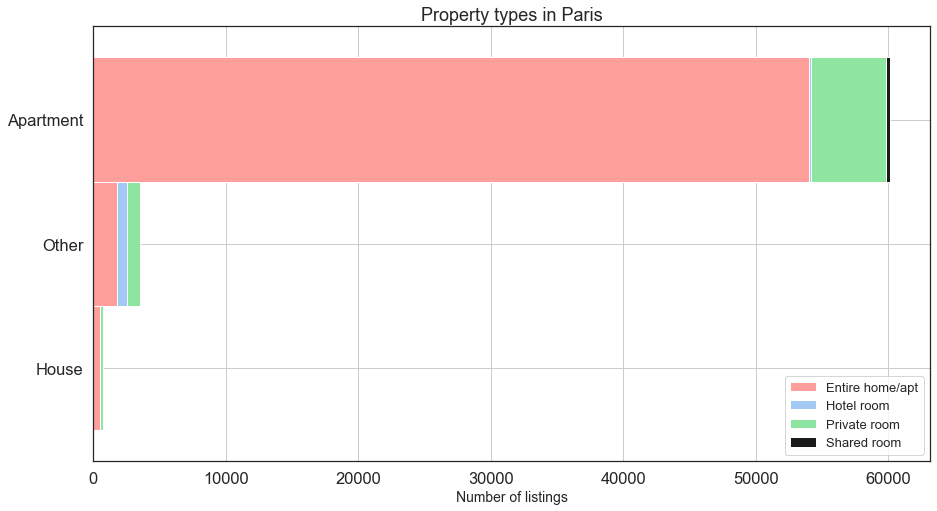

<Figure size 842.4x595.44 with 0 Axes>

In [101]:
# This graph shows the distribution of property_types and what room type they consist of.
# Most properties consists of entire homes and the most frequent property type is apartment, which makes sence being in a major city.
prop = raw_data.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = ["r","b","g","k"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Property types in Paris', fontsize=18)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()
plt.savefig('data/Propertytypes.png')

In [102]:
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop['total']

property_type
House          710.0
Other         3494.0
Apartment    59833.0
Name: total, dtype: float64

## cancellation_policy

In [103]:
raw_data.cancellation_policy.value_counts()

strict_14_with_grace_period    24381
flexible                       21974
moderate                       17677
super_strict_60                  272
super_strict_30                  119
strict                             3
Name: cancellation_policy, dtype: int64

In [104]:
# Replacing categories
raw_data.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period'
    }, inplace=True)

In [105]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64426 entries, 3109 to 42912016
Data columns (total 59 columns):
accommodates                      64426 non-null int64
bathrooms                         64426 non-null float64
bedrooms                          64426 non-null float64
cleaning_fee                      64426 non-null float64
security_deposit                  64426 non-null float64
extra_people                      64426 non-null float64
guests_included                   64426 non-null int64
distance                          64426 non-null float64
size                              64426 non-null float64
listing_url                       64426 non-null object
description                       64426 non-null object
host_since                        64426 non-null datetime64[ns]
host_response_time                64426 non-null object
host_response_rate                64426 non-null object
host_acceptance_rate              64426 non-null object
host_is_superhost               

In [106]:
raw_data.to_csv('data/raw_data_preprocessed')